In [6]:
import os
import torch
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
from itertools import product
import json
from collections import defaultdict

from torch import nn
from torch.autograd import Variable
from torch.functional import F
from torchvision import models
import torchvision
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np

# from fastai import transforms, model, dataset, conv_learner

from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from augmentation import SSDAugmentation

from Config import Config
from SSD_model import get_SSD_model, lr_find
from VOC_data import VOC_dataset
from SSDloss import *

In [20]:
def detection_collate_fn(batch):
    imgs, bboxes, labels = [], [], []
    for i, b, l in batch:
        imgs.append(i); bboxes.append(b); labels.append(l)
    return torch.stack(imgs), bboxes, labels

In [21]:
trn_id_fname, trn_id_annotation, trn_id_single_anno, idx_category, category_idx, imgs, imgs_id, imgs_bbox, imgs_class = get_anno_data()

In [22]:
config = Config('local')
trn_dataset = VOC_dataset(config.voc2007_root, config.voc2007_trn_anno)

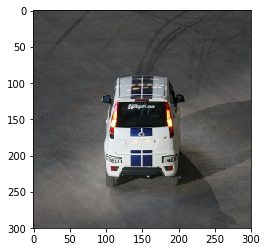

In [35]:
idx = 0
img, bbox, label = trn_dataset[idx]

img_ = img.permute(1, 2, 0)
img_ = np.array(img_ + torch.FloatTensor([123, 117, 104]), dtype=np.int)

plt.imshow(img_)

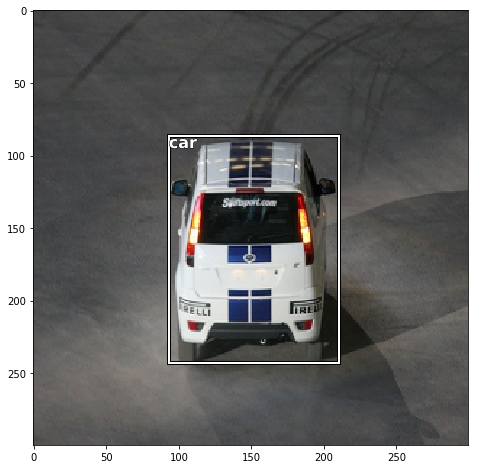

In [36]:
draw_im_with_data(img_, bbox * 300, label, idx_category)

In [37]:
bbox

array([[0.31     , 0.2882883, 0.702    , 0.8108108]], dtype=float32)

In [53]:
img

tensor([[[ -54.835,  -56.000,  -58.612,  ...,  -64.073,  -68.110,  -71.000],
         [ -52.880,  -55.835,  -57.997,  ...,  -64.893,  -68.845,  -69.900],
         [ -56.692,  -55.550,  -58.108,  ...,  -61.292,  -61.900,  -63.142],
         ...,
         [ -46.125,  -44.550,  -44.883,  ...,  -38.708,  -39.825,  -39.950],
         [ -43.162,  -41.495,  -42.385,  ...,  -40.952,  -44.010,  -43.120],
         [ -40.777,  -40.055,  -41.685,  ...,  -42.297,  -43.110,  -44.000]],

        [[ -48.835,  -50.000,  -52.612,  ...,  -58.073,  -60.110,  -63.000],
         [ -46.880,  -49.835,  -51.997,  ...,  -58.893,  -60.845,  -61.900],
         [ -50.692,  -49.550,  -52.108,  ...,  -55.658,  -53.900,  -55.142],
         ...,
         [ -41.125,  -39.550,  -40.550,  ...,  -33.375,  -33.825,  -33.950],
         [ -38.162,  -36.495,  -38.052,  ...,  -35.618,  -38.010,  -37.120],
         [ -35.777,  -35.055,  -37.352,  ...,  -36.333,  -36.165,  -38.000]],

        [[ -37.835,  -39.000,  -40.278,  ...

In [38]:
config = Config('local')
ssd_model = get_SSD_model(1, config.vgg_weight_path, config.vgg_reduced_weight_path)
ssd_model.load_trained_model(config.trained_path)

print('success build ssd model')

train_dataset = VOC_dataset(config.voc2007_root, config.voc2007_trn_anno)

conf, loc = ssd_model(img.unsqueeze(0))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
ssd_model = ssd_model.to(device)

# bbox = np.array([[ 0.38333332538604736328,  0.16758242249488830566,
#            0.57916665077209472656,  0.54395604133605957031],
#          [ 0.18541666865348815918,  0.21153846383094787598,
#            0.83749997615814208984,  0.92032968997955322266]], dtype=np.float32)

priors = get_prior_box()
iou = get_iou(bbox, priors)

D:\1-usc\SSD_PyTorch\SSD_model.py:180: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(m.weight.data)


success build ssd model


In [39]:
pos_mask, cls_target, bbox_target = get_target(iou, priors, img, bbox, label)
neg_mask = 1 - pos_mask

In [40]:
d_bbox = decode(bbox_target, priors, [0.1, 0.2])

loc_p = loc[(pos_mask).unsqueeze(0)].view(-1, 4)
loc_t = bbox_target[pos_mask].view(-1, 4)
loss_l = F.smooth_l1_loss(loc_p, loc_t, size_average=False)

D:\py3\anaconda3\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [41]:
# loss_loc should be 8.441 not 2.110, wrong summation

loss_loc, loss_cls = loss(conf[0], loc[0], pos_mask, cls_target, bbox_target)

D:\py3\anaconda3\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


tensor(22.174, grad_fn=<SumBackward0>) tensor(16.127, grad_fn=<SumBackward0>) tensor(12.359, grad_fn=<SumBackward0>)


In [50]:
torch.sum(pos_mask)

tensor(16)

In [51]:
torch.sum(loss_loc) * 16

tensor(12.359, grad_fn=<MulBackward>)

In [52]:
torch.sum(loss_cls) * 16

tensor(38.302, grad_fn=<MulBackward>)

In [16]:
loss_loc

tensor([[1.424e-03, 6.691e-05, 4.196e-04, 1.573e-09],
        [8.979e-04, 1.223e-04, 1.575e-03, 1.452e-03],
        [2.625e-04, 1.539e-03, 3.130e-06, 2.741e-04],
        [1.993e-03, 1.492e-03, 8.567e-04, 6.399e-04],
        [3.745e-04, 3.010e-03, 7.663e-04, 3.636e-03],
        [5.567e-04, 5.301e-04, 7.083e-04, 5.216e-05],
        [8.681e-04, 9.911e-04, 3.066e-04, 1.281e-04],
        [8.782e-03, 2.957e-04, 2.764e-04, 1.899e-03],
        [1.759e-03, 8.687e-03, 6.913e-04, 3.272e-04],
        [4.241e-03, 8.878e-04, 1.640e-03, 4.665e-04],
        [2.988e-05, 4.821e-03, 1.777e-04, 7.464e-04],
        [2.174e-05, 1.844e-03, 4.450e-04, 1.149e-05],
        [1.404e-02, 7.930e-03, 8.423e-03, 2.243e-04],
        [2.239e-02, 1.018e-02, 8.806e-06, 4.154e-05],
        [3.635e-05, 2.925e-03, 4.559e-02, 2.224e-03],
        [2.397e-03, 9.359e-03, 8.521e-04, 1.694e-03],
        [3.012e-03, 8.938e-03, 2.015e-03, 1.023e-03],
        [4.831e-03, 8.022e-03, 3.553e-03, 3.540e-03],
        [9.282e-03, 2.267e-0

In [18]:
c = nn.SmoothL1Loss(reduce=False)
l = loc[0]
l_ = c(l[pos_mask], bbox_target[pos_mask])

D:\py3\anaconda3\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [23]:
loss_conf = F.cross_entropy(conf[0], cls_target.long(), reduction='none')

In [24]:
torch.sum(loss_conf)

tensor(54.362, grad_fn=<SumBackward0>)

In [28]:
loss_c_pos = torch.sum(loss_conf[pos_mask])

In [29]:
loss_c_pos

tensor(17.477, grad_fn=<SumBackward0>)

In [30]:
num_pos = torch.sum(pos_mask)
ratio = 3

In [125]:
_, neg_idx = torch.sort(loss_conf[neg_mask], descending=True)

In [126]:
loss_c_neg = loss_conf[neg_mask][neg_idx[:num_pos * ratio]]

In [128]:
torch.sum(loss_c_neg)

tensor(8.564, grad_fn=<SumBackward0>)

In [129]:
loss_c_pos + torch.sum(loss_c_neg)

tensor(26.041, grad_fn=<ThAddBackward>)

In [110]:
x = torch.randn(4, 4)
y = torch.randn(4, 1)
w = nn.Parameter(torch.randn(4, 1))
b = nn.Parameter(torch.randn(1, 1))

pred = torch.matmul(x, w) + b
conf_loss = F.smooth_l1_loss(pred, y, reduction='none')

conf_loss

tensor([[3.997],
        [0.452],
        [1.382],
        [3.567]], grad_fn=<SmoothL1LossBackward>)

In [115]:
_, idx = torch.sort(conf_loss, dim=0, descending=True)
total_conf_loss = torch.sum(conf_loss[idx[:2]]) / 2
total_conf_loss

l1, l2, l3, l4 = conf_loss

l = (l1 + l4) / 2

In [116]:
total_conf_loss

tensor(3.782, grad_fn=<DivBackward0>)

In [117]:
l

tensor([3.782], grad_fn=<DivBackward0>)

In [118]:
l.backward(retain_graph=True)

In [119]:
b.grad

tensor([[1.]])

In [120]:
b.grad = torch.zeros(1, 1)

In [121]:
b.grad

tensor([[0.]])

In [122]:
total_conf_loss.backward(retain_graph=True)

In [123]:
b.grad

tensor([[1.]])

In [6]:
prior_box = get_prior_box()
loss_array = []

for i, batch in enumerate(trn_dataloader):

    imgs, bboxes, labels = batch
    imgs = imgs.to(device)
    cls_preds, loc_preds = ssd_model(imgs)

#     model.zero_grad()

    total_loss = 0
    total_loc_loss, total_cls_loss = 0, 0

    for idx in range(imgs.shape[0]):

        img, bbox, label = imgs[idx], bboxes[idx], labels[idx]
        cls_pred, loc_pred = cls_preds[idx], loc_preds[idx]
        iou = get_iou(bbox, prior_box)

        pos_mask, cls_target, bbox_target = get_target(iou, prior_box, img, bbox, label)
        pos_mask, cls_target, bbox_target = pos_mask.to(device), cls_target.to(device), bbox_target.to(device)

        loss_loc, loss_cls = loss(cls_pred, loc_pred, pos_mask, cls_target, bbox_target)
        total_loc_loss += loss_loc; total_cls_loss += loss_cls

        total_loss += (loss_cls + loss_loc)

    total_loss /= float(imgs.shape[0])
    total_cls_loss /= float(imgs.shape[0])
    total_loc_loss /= float(imgs.shape[0])

#     total_loss.backward()

#     optimizer.step()
    cls_loss = round(float(total_cls_loss), 3)
    loc_loss = round(float(total_loc_loss), 3)
    t_loss = round(float(total_loss), 3)

    print(i, 'cls_loss: {}, loc_loss: {}, loss: {}'.format(cls_loss, loc_loss, t_loss))
    loss_array.append(t_loss)

D:\py3\anaconda3\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


0 cls_loss: 9.103, loc_loss: 4.608, loss: 13.711
1 cls_loss: 9.528, loc_loss: 3.767, loss: 13.295
2 cls_loss: 9.228, loc_loss: 3.088, loss: 12.316
3 cls_loss: 9.208, loc_loss: 7.935, loss: 17.142
4 cls_loss: 8.811, loc_loss: 4.791, loss: 13.602
5 cls_loss: 8.592, loc_loss: 4.327, loss: 12.92
6 cls_loss: 8.326, loc_loss: 3.546, loss: 11.872
7 cls_loss: 9.201, loc_loss: 9.054, loss: 18.254
8 cls_loss: 8.948, loc_loss: 10.308, loss: 19.256
9 cls_loss: 10.047, loc_loss: 5.539, loss: 15.586
10 cls_loss: 10.427, loc_loss: 4.072, loss: 14.499
11 cls_loss: 6.396, loc_loss: 5.328, loss: 11.724
12 cls_loss: 9.155, loc_loss: 4.246, loss: 13.401
13 cls_loss: 6.205, loc_loss: 7.109, loss: 13.314
14 cls_loss: 9.29, loc_loss: 5.714, loss: 15.004
15 cls_loss: 7.516, loc_loss: 4.717, loss: 12.234
16 cls_loss: 8.497, loc_loss: 6.005, loss: 14.503
17 cls_loss: 8.481, loc_loss: 6.423, loss: 14.904
18 cls_loss: 10.271, loc_loss: 4.646, loss: 14.917
19 cls_loss: 9.056, loc_loss: 6.009, loss: 15.066
20 cls_l

323 cls_loss: 7.187, loc_loss: 5.416, loss: 12.602
324 cls_loss: 9.172, loc_loss: 5.714, loss: 14.886
325 cls_loss: 8.605, loc_loss: 7.542, loss: 16.147
326 cls_loss: 10.065, loc_loss: 6.727, loss: 16.792
327 cls_loss: 8.126, loc_loss: 5.625, loss: 13.752
328 cls_loss: 8.215, loc_loss: 7.198, loss: 15.412
329 cls_loss: 6.03, loc_loss: 4.316, loss: 10.346
330 cls_loss: 10.816, loc_loss: 7.623, loss: 18.44
331 cls_loss: 10.078, loc_loss: 6.571, loss: 16.649
332 cls_loss: 10.149, loc_loss: 4.471, loss: 14.62
333 cls_loss: 9.258, loc_loss: 9.792, loss: 19.051
334 cls_loss: 11.693, loc_loss: 3.753, loss: 15.446
335 cls_loss: 5.477, loc_loss: 12.576, loss: 18.053
336 cls_loss: 7.871, loc_loss: 4.874, loss: 12.745
337 cls_loss: 8.877, loc_loss: 4.493, loss: 13.37
338 cls_loss: 7.909, loc_loss: 5.69, loss: 13.599
339 cls_loss: 8.332, loc_loss: 7.047, loss: 15.379
340 cls_loss: 8.8, loc_loss: 8.016, loss: 16.816
341 cls_loss: 9.133, loc_loss: 7.441, loss: 16.574
342 cls_loss: 9.842, loc_loss: 3

KeyboardInterrupt: 

In [13]:
cls_target[pos_mask]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3], device='cuda:0', dtype=torch.int32)

In [20]:
(cls_pred[pos_mask].shape)

torch.Size([78, 21])

In [2]:
import torch
from torch import nn

In [42]:
l = nn.Conv2d(1, 1, kernel_size=(3, 3), stride=1, padding=0)
l.weight = nn.Parameter(torch.ones(1, 1, 3, 3).float())
x = torch.zeros(35)
for i in range(25):
    x[i] = i
x = x.reshape(1, 1, 5, 7)
x.shape

torch.Size([1, 1, 5, 7])

In [43]:
l.weight

Parameter containing:
tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]], requires_grad=True)

In [44]:
l.bias = nn.Parameter(torch.FloatTensor([0]))

In [45]:
x

tensor([[[[ 0.,  1.,  2.,  3.,  4.,  5.,  6.],
          [ 7.,  8.,  9., 10., 11., 12., 13.],
          [14., 15., 16., 17., 18., 19., 20.],
          [21., 22., 23., 24.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]]]])

In [64]:
torch.reshape(l(x), (-1, 1))

tensor([[ 72.],
        [ 81.],
        [ 90.],
        [ 99.],
        [108.],
        [135.],
        [144.],
        [128.],
        [111.],
        [ 93.],
        [111.],
        [117.],
        [ 98.],
        [ 78.],
        [ 57.]], grad_fn=<AsStridedBackward>)

In [65]:
x.shape

torch.Size([1, 1, 5, 7])

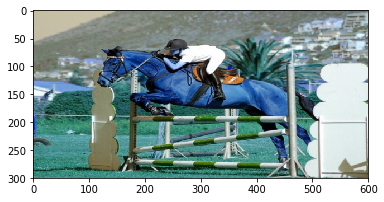

In [47]:
img1_path, img2_path = 'C:\\datasets\\pascal\\JPEGImages\\000012.jpg', 'C:\\datasets\\pascal\\JPEGImages\\000017.jpg'
img1, img2 = cv2.imread(img1_path), cv2.imread(img2_path)
img1, img2 = cv2.resize(img1, (600, 300)), cv2.resize(img2, (600, 300))

plt.imshow(img2)

In [48]:
img2.shape

(300, 600, 3)

In [51]:
x.reshape(35)

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.])